In [18]:
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cbpro

import os
import shutil
import urllib
import zipfile
from pathlib import Path
import seaborn as sns

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

tf.distribute.OneDeviceStrategy(device="/gpu:0")
policy = tf.keras.mixed_precision.Policy("mixed_float16")
tf.keras.mixed_precision.experimental.set_policy(policy)
np.set_printoptions(suppress=True)

public_client = cbpro.PublicClient()

In [19]:
class MinerMeta(type):
    def compile_historic(self, timestamp=False, write_csv=False, read_csv=False):
        file = Path.cwd() / f"{self.coin}_histdata.csv"
        if read_csv == True:
            df = pd.read_csv(file, index_col="time", infer_datetime_format=True)
            return df
        else:
            start_date = datetime(2020, 1, 1)
            end_date = datetime.today()
            delta = timedelta(hours=300)
            df = pd.DataFrame()

        while start_date <= end_date:
            historic = public_client.get_product_historic_rates(
                f"{self.coin}-USD",
                granularity=3600,
                start=start_date,
                end=start_date + delta,
            )
            start_date += delta
            df = df.append(historic, ignore_index=True)
        df.columns = ["time", "low", "high", "open", "close", "volume"]
        date_time = pd.to_datetime(df["time"], unit="s")

        timestamp_s = date_time.map(pd.Timestamp.timestamp)
        day = 24 * 60 * 60
        year = (365.2425) * day
        df["Day sin"] = np.sin(timestamp_s * (2 * np.pi / day))
        df["Day cos"] = np.cos(timestamp_s * (2 * np.pi / day))
        df["Year sin"] = np.sin(timestamp_s * (2 * np.pi / year))
        df["Year cos"] = np.cos(timestamp_s * (2 * np.pi / year))
        df.reset_index(drop=True, inplace=True)

        if timestamp is True:
            pass
        else:
            df["time"] = pd.to_datetime(df["time"], unit="s")

        if write_csv is True:
            df.to_csv(file, index=False)

        return df

    def get_day_stats(self):
        ticker = public_client.get_product_24hr_stats(f"{self.coin}-USD")
        df = pd.DataFrame.from_dict(ticker, orient="index")
        return df

    def year_day_fft(self, col):
        df = self.compile_historic()
        today = datetime.today()

        fft = tf.signal.rfft(df[col])
        f_per_dataset = np.arange(0, len(fft))

        n_samples_h = 1
        hours_per_year = 24 * 365.2524
        years_per_dataset = n_samples_h / (hours_per_year)

        f_per_year = f_per_dataset / years_per_dataset
        plt.step(f_per_year, np.abs(fft))
        plt.xscale("log")
        plt.ylim(1000, 50000)
        plt.xlim([0.1, max(plt.xlim())])
        plt.xticks([1, 365.2524], labels=["1/Year", "1/day"])
        plt.xlabel("Frequency (log scale)")

        return plt.show()

    def ttsplit_norm(self, df, split_time=0.7, feature_plot=False):
        # train_df Test Split
        n = len(df)
        train_df_df = df[0 : int(n * 0.7)]
        val_df = df[int(n * 0.7) : int(n * 0.9)]
        test_df = df[int(n * 0.9) :]
        # Normalize the Data
        train_df_mean = train_df_df.mean()
        train_df_std = train_df_df.std()

        train_df_df = (train_df_df - train_df_mean) / train_df_std
        val_df = (val_df - train_df_mean) / train_df_std
        test_df = (test_df - train_df_mean) / train_df_std

        # Create Feature Plot if wanted
        if feature_plot is True:
            df_std = (df - train_df_mean) / train_df_std
            df_std = df_std.melt(var_name="Column", value_name="Normalized")
            plt.figure(figsize=(12, 6))
            ax = sns.violinplot(x="Column", y="Normalized", data=df_std)
            ax.set_xticklabels(df.keys(), rotation=90)
            ax.set_title("train_dfing Data Feature Dist with whole DF Mean")

            return train_df_df, val_df, test_df

        return train_df_df, val_df, test_df

    def __call__(self, *args, **kwargs):

        cls = type.__call__(self, *args)

        setattr(cls, "compile_historic", self.compile_historic)
        setattr(cls, "year_day_fft", self.year_day_fft)
        setattr(cls, "ttsplit_norm", self.ttsplit_norm)
        # setattr(cls, "make_dataset", self.compile_historic)

        # for key, value in historic.items():
        #     setattr(cls, "hist_" + key, value)
        # for key, value in ticker.items():
        #     setattr(cls, "tick_" + key, value)

        return cls


class WindowGenerator:
    def __init__(
        self,
        input_width,
        label_width,
        shift,
        train_df_df,
        val_df,
        test_df,
        label_columns=None,
    ):
        # Store the raw data.
        self.train_df_df = train_df_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {name: i for i, name in enumerate(train_df_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ],
                axis=-1,
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def __repr__(self):
        return "\n".join(
            [
                f"Total window size: {self.total_window_size}",
                f"Input indices: {self.input_indices}",
                f"Label indices: {self.label_indices}",
                f"Label column name(s): {self.label_columns}",
            ]
        )


class eth(metaclass=MinerMeta):
    coin = "eth"


In [21]:
df = eth.compile_historic(read_csv=True)
train_df, val_df, test_df = eth.ttsplit_norm(df)
# df = df[df.index >= datetime(2021, 9, 1)]

# df.head()


In [23]:
w1 = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=24,
    label_columns=["close"],
    train_df_df=train_df,
    test_df=test_df,
    val_df=val_df,
)
w1
w2 = WindowGenerator(
    input_width=6,
    label_width=1,
    shift=1,
    label_columns=["close"],
    train_df_df=train_df,
    test_df=test_df,
    val_df=val_df,
)
w2


Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['close']

In [24]:
# Stack three slices, the length of the total window.
example_window = tf.stack(
    [
        np.array(train_df[: w2.total_window_size]),
        np.array(train_df[100 : 100 + w2.total_window_size]),
        np.array(train_df[200 : 200 + w2.total_window_size]),
    ]
)

example_inputs, example_labels = w2.split_window(example_window)

print("All shapes are: (batch, time, features)")
print(f"Window shape: {example_window.shape}")
print(f"Inputs shape: {example_inputs.shape}")
print(f"Labels shape: {example_labels.shape}")

w2.example = example_inputs, example_labels


All shapes are: (batch, time, features)
Window shape: (3, 7, 9)
Inputs shape: (3, 6, 9)
Labels shape: (3, 1, 1)


In [25]:
def plot(self, model=None, plot_col="close", max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n + 1)
        plt.ylabel(f"{plot_col} [normed]")
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label="Inputs",
            marker=".",
            zorder=-10,
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(
            self.label_indices,
            labels[n, :, label_col_index],
            edgecolors="k",
            label="Labels",
            c="#2ca02c",
            s=64,
        )
        if model is not None:
            predictions = model(inputs)
            plt.scatter(
                self.label_indices,
                predictions[n, :, label_col_index],
                marker="X",
                edgecolors="k",
                label="Predictions",
                c="#ff7f0e",
                s=64,
            )

        if n == 0:
            plt.legend()

    plt.xlabel("Time [h]")


WindowGenerator.plot = plot


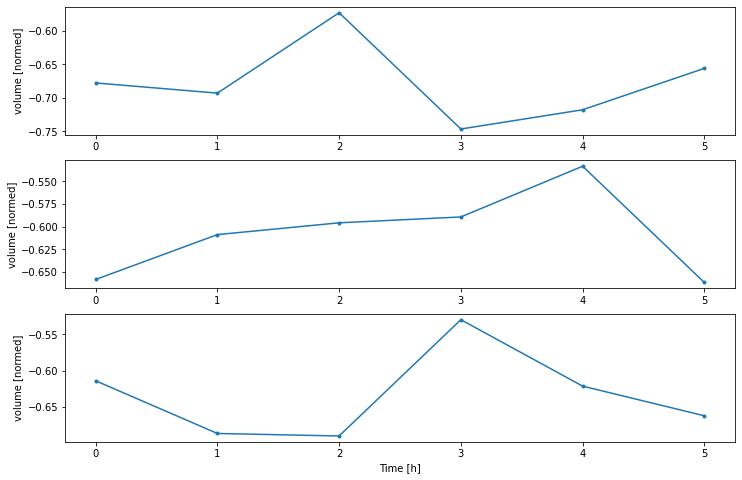

In [26]:
w2.plot(plot_col="volume")
